In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
X, y = pd.read_csv('task-1-brain-age-prediction/X_train.csv'), pd.read_csv('task-1-brain-age-prediction/y_train.csv')

In [3]:
X.drop(labels='id', axis=1, inplace=True)
y.drop(labels='id', axis=1, inplace=True)

In [4]:
# data imputing with the median
X.fillna(X.median(), inplace=True)

In [5]:
print(X.shape)
X = X.drop_duplicates()
print(X.shape)

(1212, 832)
(1212, 832)


In [6]:
# Remove columns with zero variance
mask_ = X.var(axis=0) != 0
X = X.loc[:, mask_]
print(X.shape)

(1212, 828)


In [7]:
print(X.isnull().sum().sum()) # check imputer

0


In [8]:
print(X.shape, y.shape)

(1212, 828) (1212, 1)


In [77]:
# compute the feature_corr
print(f'Shape before feature selection (X) is {(X.shape)}')
feature_corr = X.corrwith(y.squeeze()) >= 0.1
X = X.loc[:, feature_corr]
print(f'Shape after feature selection (X) is {(X.shape)}')

Shape before feature selection (X) is (1212, 828)
Shape after feature selection (X) is (1212, 28)


In [78]:
def filter_multicolinearity(X_train, sigma):
    corr_matrix = np.triu(np.corrcoef(X_train, rowvar=False))
    np.fill_diagonal(corr_matrix, val=0)
    mask_multicorr = (corr_matrix < sigma).all(axis=1)
    return mask_multicorr

print(f'Shape before feature selection (X) is {(X.shape)}')
sigma_th = 0.8
mask_features = filter_multicolinearity(X, sigma_th)
X = X.loc[:, mask_features]
print(f'Shape after feature selection (X) is {(X.shape)}')

Shape before feature selection (X) is (1212, 28)
Shape after feature selection (X) is (1212, 21)


In [79]:

print(X.shape)

(1212, 21)


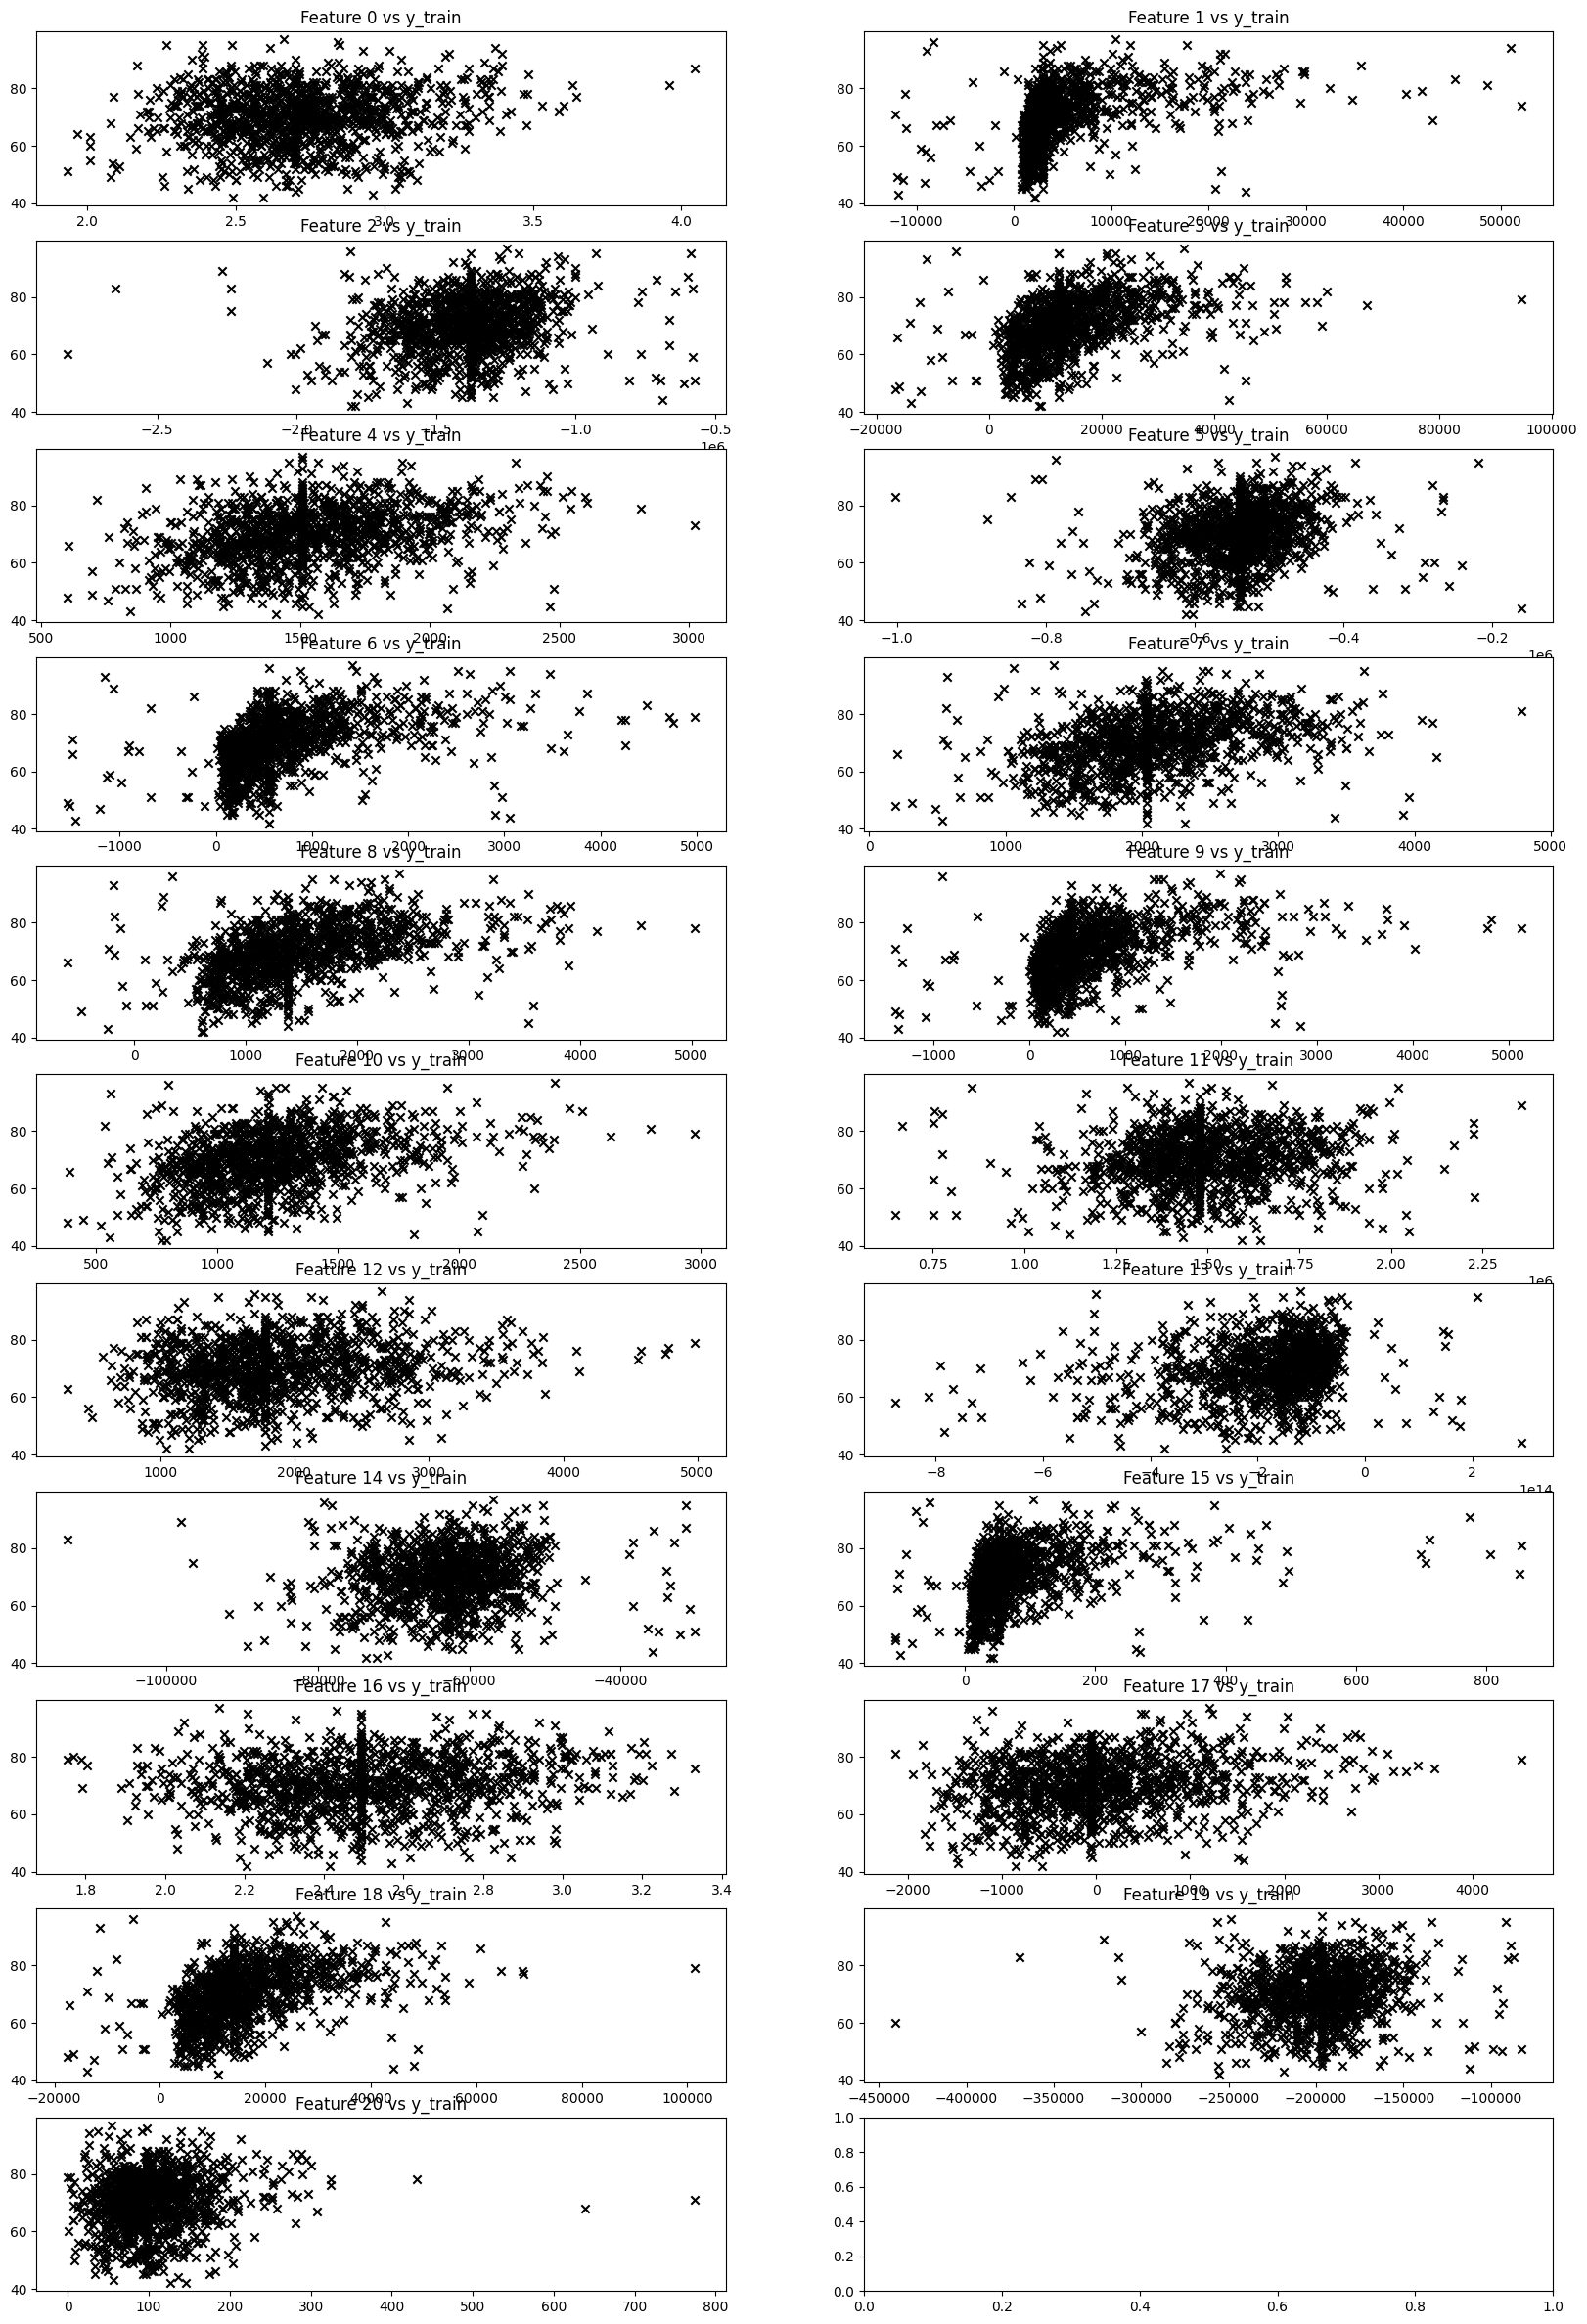

In [80]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(11, 2, figsize=(20, 30))
for i in range(21):
    axes[i // 2, i % 2].scatter(X.iloc[:, i], y, marker='x', color='black')
    axes[i // 2, i % 2].set_title(f'Feature {i} vs y_train')

plt.show()

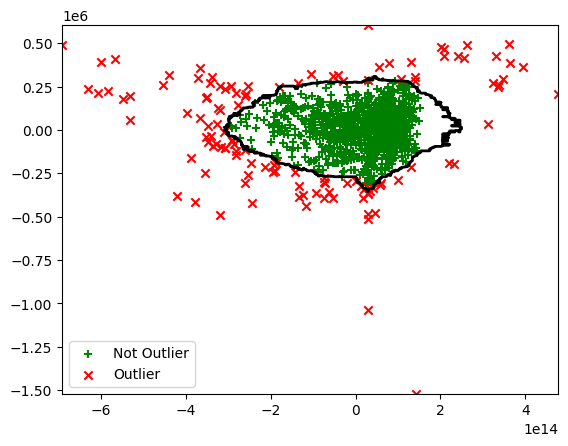

In [81]:
# Outlier Detection

from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope

fig, ax = plt.subplots()

# Consider the points (x, y) jointly
Xy = pd.concat([X, y], axis=1)
pca = PCA(n_components=2)
Xy_project = pca.fit_transform(Xy)

# Outlier analysis --> EllipticEnvelope (Gaussian)
xx, yy = np.meshgrid(np.linspace(Xy_project[:, 0].min(), \
Xy_project[:, 0].max(), 1000), np.linspace(Xy_project[:, 1].min(), \
    Xy_project[:, 1].max(), 1000))

elliptic_env = IsolationForest(contamination=0.05)
outliers = elliptic_env.fit_predict(Xy_project)
mask_outliers_out = outliers != -1
Xy_project_not_outliers = Xy_project[mask_outliers_out, :]
Xy_project_outliers = Xy_project[~mask_outliers_out, :]

ax.scatter(Xy_project_not_outliers[:, 0], Xy_project_not_outliers[:, 1], marker='+', color='green')
ax.scatter(Xy_project_outliers[:, 0], Xy_project_outliers[:, 1], marker='x', color='red')
Z = elliptic_env.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")
ax.legend(['Not Outlier', 'Outlier'])

plt.show()

In [82]:
print((outliers == -1).sum())

122


In [83]:
# Filter out all of the outliers
print(X.shape)
X = X.loc[mask_outliers_out, :]
print(X.shape)

(1212, 21)
(1090, 21)


In [84]:
y = y.loc[mask_outliers_out]

In [85]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [86]:
print(type(X_train), type(X_test), type(y_train), type(y_test))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


In [87]:
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import RobustScaler

svr = Pipeline([ 
    ('scaler', RobustScaler()),
    ('svr', SVR())
])
param_grid = { 
    'svr__kernel' : ['poly', 'rbf', 'sigmoid'], 
    'svr__gamma' : ['scale', 'auto'], 
    'svr__C': [ 1e-1, 1, 1e1, 1e2, 1e3]
}

grid = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0, scoring='r2', error_score="raise", refit=True)
grid.fit(X_train, y_train.squeeze())

svr_best_estimator = grid.best_estimator_

r2_score_train = r2_score(y_train, svr_best_estimator.predict(X_train))
r2_score_test = r2_score(y_test, svr_best_estimator.predict(X_test))
print('----')
print(f'Train r2 score: {r2_score_train}')
print(f'Test r2 score: {r2_score_test}')
print('----')

----
Train r2 score: 0.6688115834386326
Test r2 score: 0.5525623727690909
----


In [88]:
print(grid.best_params_)

{'svr__C': 10.0, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}


In [89]:
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

svr_std = Pipeline([ 
    ('scaler', StandardScaler()),
    ('svr', SVR())
])
param_grid = { 
    'svr__kernel' : ['poly', 'rbf', 'sigmoid'], 
    'svr__gamma' : ['scale', 'auto'], 
    'svr__C': [1e-1, 1, 1e1, 1e2]
}

grid = GridSearchCV(estimator=svr_std, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0, scoring='r2', error_score="raise", refit=True)
grid.fit(X_train, y_train.squeeze())

svr_std_best_estimator = grid.best_estimator_

r2_score_train = r2_score(y_train, svr_std_best_estimator.predict(X_train))
r2_score_test = r2_score(y_test, svr_std_best_estimator.predict(X_test))
print('----')
print(f'Train r2 score: {r2_score_train}')
print(f'Test r2 score: {r2_score_test}')
print('----')

----
Train r2 score: 0.6840608201890386
Test r2 score: 0.5573056777896185
----


In [90]:
print(grid.best_params_)

{'svr__C': 10.0, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}


In [91]:
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import QuantileTransformer

svr_normal = Pipeline([ 
    ('scaler', QuantileTransformer(n_quantiles=X_train.shape[0], output_distribution='normal')),
    ('svr', SVR())
])
param_grid = { 
    'svr__kernel' : ['poly', 'rbf', 'sigmoid'], 
    'svr__gamma' : ['scale', 'auto'], 
    'svr__C': [1e-1, 1, 1e1, 1e2]
}

grid = GridSearchCV(estimator=svr_normal, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0, scoring='r2', error_score="raise", refit=True)
grid.fit(X_train, y_train.squeeze())

svr_normal_best_estimator = grid.best_estimator_

r2_score_train = r2_score(y_train, svr_normal_best_estimator.predict(X_train))
r2_score_test = r2_score(y_test, svr_normal_best_estimator.predict(X_test))
print('----')
print(f'Train r2 score: {r2_score_train}')
print(f'Test r2 score: {r2_score_test}')
print('----')

/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (872) is greater than the total number of samples (697). n_quantiles is set to n_samples.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (872) is greater than the total number of samples (698). n_quantiles is set to n_samples.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (872) is greater than the total number of samples (698). n_quantiles is set to n_samples.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (872) is greater than the total number of samples (697). n_quantiles is set to n_samples.
 

----
Train r2 score: 0.7245648381555152
Test r2 score: 0.5814639352441212
----


In [92]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

random_forest_regressor = Pipeline([ 
    ('scaler', StandardScaler()),
    ('random_forest_regressor', RandomForestRegressor())
])

param_grid = { 
    'random_forest_regressor__n_estimators' : [50, 100, 150, 200, 250], 
    'random_forest_regressor__criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'random_forest_regressor__max_depth' : [3, 5, 7, 9, 11, 13, 15, 17]
}

grid = GridSearchCV(estimator=random_forest_regressor, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0, scoring='r2', error_score="raise", refit=True)
grid.fit(X_train, y_train.squeeze())

random_forest_regressor_best_estimator = grid.best_estimator_

r2_score_train = r2_score(y_train, random_forest_regressor_best_estimator.predict(X_train))
r2_score_test = r2_score(y_test, random_forest_regressor_best_estimator.predict(X_test))
print('----')
print(f'Train r2 score: {r2_score_train}')
print(f'Test r2 score: {r2_score_test}')
print('----')

/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----
Train r2 score: 0.9132189324223681
Test r2 score: 0.5612570585337251
----


In [107]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

random_forest_regressor_without = Pipeline([ 
    ('random_forest_regressor', RandomForestRegressor())
])

param_grid = { 
    'random_forest_regressor__n_estimators' : [50, 100, 150, 200, 250], 
    'random_forest_regressor__criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'random_forest_regressor__max_depth' : [3, 5, 7, 9, 11, 13, 15, 17]
}

grid = GridSearchCV(estimator=random_forest_regressor_without, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0, scoring='r2', error_score="raise", refit=True)
grid.fit(X_train, y_train.squeeze())

random_forest_regressor_without_best_estimator = grid.best_estimator_

r2_score_train = r2_score(y_train, random_forest_regressor_without_best_estimator.predict(X_train))
r2_score_test = r2_score(y_test, random_forest_regressor_without_best_estimator.predict(X_test))
print('----')
print(f'Train r2 score: {r2_score_train}')
print(f'Test r2 score: {r2_score_test}')
print('----')

/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----
Train r2 score: 0.9270984825673524
Test r2 score: 0.5575199417143433
----


In [93]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

random_forest_regressor_quant = Pipeline([ 
    ('scaler', QuantileTransformer(n_quantiles=X_train.shape[0], output_distribution='normal')),
    ('random_forest_regressor', RandomForestRegressor())
])

param_grid = { 
    'random_forest_regressor__n_estimators' : [50, 100, 150, 200, 250], 
    'random_forest_regressor__criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'random_forest_regressor__max_depth' : [3, 5, 7, 9, 11, 13, 15, 17]
}

grid = GridSearchCV(estimator=random_forest_regressor_quant, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0, scoring='r2', error_score="raise", refit=True)
grid.fit(X_train, y_train.squeeze())

random_forest_regressor_quant_best_estimator = grid.best_estimator_

r2_score_train = r2_score(y_train, random_forest_regressor_quant_best_estimator.predict(X_train))
r2_score_test = r2_score(y_test, random_forest_regressor_quant_best_estimator.predict(X_test))
print('----')
print(f'Train r2 score: {r2_score_train}')
print(f'Test r2 score: {r2_score_test}')
print('----')

/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (872) is greater than the total number of samples (697). n_quantiles is set to n_samples.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (872) is greater than the total number of samples (697). n_quantiles is set to n_samples.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (872) is greater than the total number of samples (698). n_quantiles is set to n_samples.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (872) is greater than the total number of samples (698). n_quantiles is set to n_samples.
 

----
Train r2 score: 0.9286811923459773
Test r2 score: 0.5656557741533802
----


In [94]:
print(grid.best_params_)

{'random_forest_regressor__criterion': 'squared_error', 'random_forest_regressor__max_depth': 15, 'random_forest_regressor__n_estimators': 200}


In [101]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import PolynomialFeatures

kernel_ridge_regressor = Pipeline([ 
    ('scaler', StandardScaler()),
    ('kernel_ridge', KernelRidge())
])

param_grid = { 
    'kernel_ridge__alpha' : [1e-2, 1e-1, 1, 1e1, 1e2, 1e3], 
    'kernel_ridge__kernel': ['poly', 'rbf', 'linear', 'laplacian'],
}

grid = GridSearchCV(estimator=kernel_ridge_regressor, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0, scoring='r2', error_score="raise", refit=True)
grid.fit(X_train, y_train.squeeze())

kernel_ridge_regressor_best_estimator = grid.best_estimator_

r2_score_train = r2_score(y_train, kernel_ridge_regressor_best_estimator.predict(X_train))
r2_score_test = r2_score(y_test, kernel_ridge_regressor_best_estimator.predict(X_test))
print('----')
print(f'Train r2 score: {r2_score_train}')
print(f'Test r2 score: {r2_score_test}')
print('----')

----
Train r2 score: 0.954933080053081
Test r2 score: 0.4879924038185922
----


In [102]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

extra_tree_reg = Pipeline([ 
    ('scaler', StandardScaler()),
    ('tree_reg', ExtraTreesRegressor())
])

param_grid = { 
    'tree_reg__n_estimators' : [50, 100, 150, 200, 250, 300], 
    'tree_reg__criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'tree_reg__max_depth': [3, 5, 7, 9, 10, 13, 15, 17], 
    'tree_reg__max_features': ['sqrt', 'log2', None]
}

grid = GridSearchCV(estimator=extra_tree_reg, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0, scoring='r2', error_score="raise", refit=True)
grid.fit(X_train, y_train.squeeze())

extra_tree_reg_best_estimator = grid.best_estimator_

r2_score_train = r2_score(y_train, extra_tree_reg_best_estimator.predict(X_train))
r2_score_test = r2_score(y_test, extra_tree_reg_best_estimator.predict(X_test))
print('----')
print(f'Train r2 score: {r2_score_train}')
print(f'Test r2 score: {r2_score_test}')
print('----')

/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----
Train r2 score: 0.9959028680484423
Test r2 score: 0.599742661475519
----


In [105]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

extra_tree_reg_without = Pipeline([ 
    ('tree_reg', ExtraTreesRegressor())
])

param_grid = { 
    'tree_reg__n_estimators' : [50, 100, 150, 200, 250, 300], 
    'tree_reg__criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'tree_reg__max_depth': [3, 5, 7, 9, 10, 13, 15, 17], 
    'tree_reg__max_features': ['sqrt', 'log2', None]
}

grid = GridSearchCV(estimator=extra_tree_reg_without, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0, scoring='r2', error_score="raise", refit=True)
grid.fit(X_train, y_train.squeeze())

extra_tree_reg_without_best_estimator = grid.best_estimator_

r2_score_train = r2_score(y_train, extra_tree_reg_without_best_estimator.predict(X_train))
r2_score_test = r2_score(y_test, extra_tree_reg_without_best_estimator.predict(X_test))
print('----')
print(f'Train r2 score: {r2_score_train}')
print(f'Test r2 score: {r2_score_test}')
print('----')

/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----
Train r2 score: 0.9993010193301114
Test r2 score: 0.6014686346226334
----


In [104]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import SplineTransformer

knn_reg = Pipeline([ 
    ('scaler', QuantileTransformer(n_quantiles=X_train.shape[0], output_distribution='normal')),
    ('knn_reg', KNeighborsRegressor())
])

param_grid = { 
    'knn_reg__n_neighbors' : [5, 10, 15, 20, 25, 30, 35],
    'knn_reg__weights' : ['uniform', 'distance'], 
    'knn_reg__metric': ['euclidean', 'l1', 'l2', 'manhattan']
}

grid = GridSearchCV(estimator=knn_reg, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0, scoring='r2', error_score="raise", refit=True)
grid.fit(X_train, y_train.squeeze())

knn_reg_best_estimator = grid.best_estimator_

r2_score_train = r2_score(y_train, knn_reg_best_estimator.predict(X_train))
r2_score_test = r2_score(y_test, knn_reg_best_estimator.predict(X_test))
print('----')
print(f'Train r2 score: {r2_score_train}')
print(f'Test r2 score: {r2_score_test}')
print('----')


/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (872) is greater than the total number of samples (697). n_quantiles is set to n_samples.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (872) is greater than the total number of samples (697). n_quantiles is set to n_samples.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (872) is greater than the total number of samples (698). n_quantiles is set to n_samples.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (872) is greater than the total number of samples (698). n_quantiles is set to n_samples.
 

----
Train r2 score: 0.9999999999999807
Test r2 score: 0.5506777301328813
----


/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (872) is greater than the total number of samples (697). n_quantiles is set to n_samples.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (872) is greater than the total number of samples (698). n_quantiles is set to n_samples.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (872) is greater than the total number of samples (698). n_quantiles is set to n_samples.
  warnings.warn(


In [47]:
print('----')
print(f'Train r2 score: {r2_score_train}')
print(f'Test r2 score: {r2_score_test}')
print(grid.best_params_)
print('----')

----
Train r2 score: 1.0
Test r2 score: 0.4171484903443533
{'knn_reg__metric': 'l1', 'knn_reg__n_neighbors': 20, 'knn_reg__weights': 'distance'}
----


In [116]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer


pipeline = Pipeline([
    ('xgb', xgb.XGBRegressor(objective='reg:squarederror'))
])
# Define the hyperparameter grid
param_grid = {
    'xgb__n_estimators': [50, 100, 200, 250],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__max_depth': [3, 5, 7, 9, 11, 13, 15, 17],
    'xgb__subsample': [0.8, 1],
    'xgb__colsample_bytree': [0.8, 1],
    'xgb__gamma': [0, 0.1, 0.3],
}

# Perform Randomized Search with Cross-Validation
random_search = RandomizedSearchCV(estimator=pipeline, 
                                   param_distributions=param_grid, 
                                   n_iter=20,  # Number of parameter combinations to try
                                   scoring='r2', 
                                   cv=5, 
                                   verbose=1, 
                                   n_jobs=-1, 
                                   random_state=42)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found: ", random_search.best_params_)
print(r2_score(y_test, random_search.best_estimator_.predict(X_test)))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found:  {'xgb__subsample': 1, 'xgb__n_estimators': 50, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.8}
0.5669761896133423


In [117]:
xgb_best = random_search.best_estimator_

In [120]:
from sklearn.ensemble import VotingRegressor

v_reg = VotingRegressor(
    estimators=[('svr_normal', svr_normal_best_estimator), # 0.5814639352441212
     ('random_forest_quant', random_forest_regressor_quant_best_estimator), # 0.5656557741533802
     ('knn_reg', knn_reg_best_estimator), # 0.5506777301328813
     ('extra_tree', extra_tree_reg_without_best_estimator), #0.6
     ('xgb_reg', xgb_best)], # 0.5669761896133423
    weights=[0.3, 0.125, 0.05, 0.4, 0.125]
)

In [121]:
v_reg.fit(X_train, y_train)
r2_score(y_test, v_reg.predict(X_test))

/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/ensemble/_voting.py:694: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5980767022457094

In [122]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import SplineTransformer
from sklearn.ensemble import GradientBoostingRegressor

gradient_booster_reg = Pipeline([ 
    ('scaler', StandardScaler()),
    ('gradient_booster_reg', GradientBoostingRegressor())
])

param_grid = { 
    'gradient_booster_reg__loss': ['squared_error', 'absolute_error', 'huber', 'quantile'], 
    'gradient_booster_reg__n_estimators': [100, 150, 200, 250, 300], 
    'gradient_booster_reg__criterion': ['friedman_mse', 'squared_error'], 
    'gradient_booster_reg__max_depth': [3, 5, 7, 9, 11, 13, 15, 17]
}

grid = GridSearchCV(estimator=gradient_booster_reg, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0, scoring='r2', error_score="raise", refit=True)
grid.fit(X_train, y_train.squeeze())

gradient_booster_reg_best_estimator = grid.best_estimator_

r2_score_train = r2_score(y_train, gradient_booster_reg_best_estimator.predict(X_train))
r2_score_test = r2_score(y_test, gradient_booster_reg_best_estimator.predict(X_test))
print('----')
print(f'Train r2 score: {r2_score_train}')
print(f'Test r2 score: {r2_score_test}')
print('----')


/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----
Train r2 score: 0.9997316893065574
Test r2 score: 0.5560287563078827
----


In [130]:
from sklearn.ensemble import VotingRegressor

v_reg = VotingRegressor(
    estimators=[('svr_normal', svr_normal_best_estimator), # 0.5814639352441212
     ('random_forest_quant', random_forest_regressor_quant_best_estimator), # 0.5656557741533802
     ('extra_tree', extra_tree_reg_without_best_estimator), #0.6
     ('xgb_reg', xgb_best)], # 0.5669761896133423
    weights=[0.20, 0.35, 0.20, 0.20]
)

In [132]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

v_reg.fit(X_train, y_train)
r2_score(y_test, v_reg.predict(X_test))

/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/ensemble/_voting.py:694: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5927094052896784

In [133]:
# Load the test data
X_test = pd.read_csv('task-1-brain-age-prediction/X_test.csv')
X_test_id = X_test['id']
X_test.drop(columns=['id'], inplace=True)

# data imputation and feature selection
mask_test = X_test.var(axis=0) != 0
X_test = X_test.loc[:, mask_]

X_test.fillna(X_test.median(), inplace=True)

print(X_test.shape, feature_corr.shape)
X_test = X_test.loc[:, feature_corr]
X_test = X_test.loc[:, mask_features]


# Make predictions
predictions = v_reg.predict(X_test)

# Create a submission file
submission = pd.DataFrame({'id': X_test_id, 'y': predictions})
submission.to_csv('submission.csv', index=False)

(776, 828) (828,)


In [31]:
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.kernel_ridge import KernelRidge

kernel_ridge = Pipeline([ 
    ('kernel_ridge', KernelRidge())
])
param_grid = { 
    'kernel_ridge__kernel' : ['poly', 'rbf', 'linear', 'laplacian'], 
    'kernel_ridge__degree' : [3, 4, 5, 6, 7], 
    'kernel_ridge__gamma' : [None, 0.1, 0.5, 1, 2, 4, 8]
}

grid = GridSearchCV(estimator=kernel_ridge, param_grid=param_grid, \
    cv=5, n_jobs=-1, verbose=0, scoring='r2', error_score="raise", refit=True)
grid.fit(X_train, y_train.squeeze())

ridge_best_estimator = grid.best_estimator_

r2_score_train = r2_score(y_train, svr_best_estimator.predict(X_train))
r2_score_test = r2_score(y_test, svr_best_estimator.predict(X_test))
print('----')
print(f'Train r2 score: {r2_score_train}')
print(f'Test r2 score: {r2_score_test}')
print('----')

/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-pack

----
Train r2 score: 0.48476877943101326
Test r2 score: 0.4692397986673502
----


In [36]:
import xgboost as xgb 

regressor=xgb.XGBRegressor(eval_metric='rmse')

regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [37]:
r2_score(y_train, regressor.predict(X_train))

0.9998144507408142

In [38]:
r2_score(y_test, regressor.predict(X_test))

0.3685252070426941

NameError: name 'y_pred' is not defined

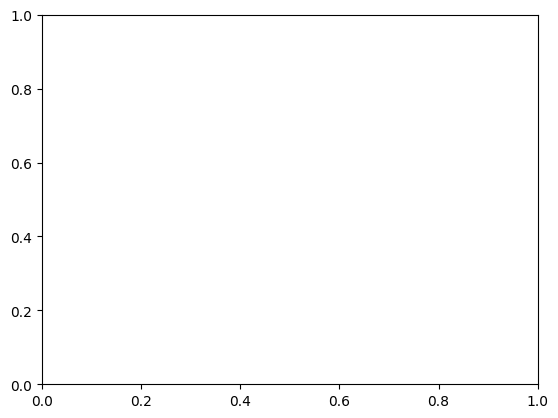

In [39]:
fig, ax = plt.subplots()
ax.scatter(x=y_test, y=y_pred, label='Ygt vs Ypred', marker='+', color='green')
ax.plot([y.min(), y.max()], [y.min(), y.max()], '--k')
plt.show()